In [1]:
# Imports
import gym
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Calling a predesigned  RL environment from the gym
env = gym.make("MountainCar-v0")
env.reset()

array([-0.41703761,  0.        ])

##### For every step, there is gonna be a observed state outputs (in this case, its pos & velo which constitutes the observation space) , we print the possible states

In [3]:
print(env.observation_space.high)
print(env.observation_space.low)
# Inference: highest value is 0.6 and least is -1.2 

[0.6  0.07]
[-1.2  -0.07]


#### In the gym, for MountainCar, there are 3 actions {0 - push left;1- stay;2 - push right;} ActionSpace = 3

In [4]:
print(env.action_space.n)

3


#### Since there will be large amount of obs states output by the systen, which makes the Q-table humongous, we form buckets that are easy to handle

In [25]:
DISCRETE_OS_SIZE = [20]* len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE

print(discrete_os_win_size)
# this gives how much incrementation is done to the range for a bucket

[0.09  0.007]


In [26]:
DISCRETE_OS_SIZE

[20, 20]

#### Random initialize a QTable.  It consists of the state vectors for every action performed

In [27]:
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))
# The rewards are between -2 and 0 ; table size = The designated Observation space size x no. of actions

print(q_table.shape)
# this has a shape of 20,20,3 --> 20x20 table for each action

(20, 20, 3)


#### Since the observation states obtained from the environment are highly granular(continous), we need to obtain 'less granular'(discretized) states. This is aided with a function to perform the discretization

In [28]:
def discretize(state):
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int)) # calling it as a tuple to easily access the q_table

In [29]:
# Initial observed states for the environment
print('pos   vel')
print(env.reset())
print(discretize(env.reset()))

pos   vel
[-0.46002234  0.        ]
(7, 10)


In [30]:
s = discretize(env.reset())
print('The q values for the observed states for all 3 actions {}'.format(q_table[s])) # these are random initialised
action = np.argmax(q_table[s])
print('The action that is chosen due to max Q value: {}'.format(action))

The q values for the observed states for all 3 actions [-1.38659972 -0.90005115 -1.91274804]
The action that is chosen due to max Q value: 1


####  Initialising parameters for the Q value function

In [31]:
LEARNING_RATE = 0.1 # step size towards convergence
DISCOUNT = 0.95 # How much do you wanna care about the future goal than a immediate reward
EPISODES = 6000 # Total no. of iterations
ep_rewards = []
agg_ep_rewards = {'ep':[],'avg':[],'min':[],'max':[]}
every = 500

In [32]:
# Exploration settings -- this is done to introduce randomness and explore the results of more actions and their rewards for better learning
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2 # half the no. of episodes
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

# Learning Routine

In [33]:
for episode in range(EPISODES):
    episode_reward = 0 # reset the rewaard every episode
    
    if episode%every ==0:

        render = True
    else:
        render = False
    
    done = False
    ds = discretize(env.reset()) # initialise discretized state
    
    while not done: # until an done ==True resulted by the action step taken
        
        if np.random.random() > epsilon:
            action = np.argmax(q_table[ds]) # best Q value in Qtable is the action chosen to perform 
        else: 
            action =  np.random.randint(0, env.action_space.n) # choose random action from actionspace
            
            
        new_state,reward,done,_ = env.step(action) # obtain the state and reward for it's  'action'
        
        episode_reward +=reward

        new_ds = discretize(new_state) # discretize the newly obtained state

        if render: # to render the car motion
            env.render()
            
        if not done: ## if learning not done in above steps, we learn Q value
            
            # To learn a new Q value, we need these two parameters
            currentQ = q_table[ds + (action,)] # find the current Q from table for the current action
            
            max_futureQ = np.max(q_table[new_ds]) # max possible Q for next step = max value in the qtable from the new observed states

            # calculate and update new Q value for this given action in the q_table.
            new_q = (1 - LEARNING_RATE) * currentQ + LEARNING_RATE * (reward + DISCOUNT * max_futureQ)  
            q_table[ds + (action,)] = new_q 

        elif new_state[0]>=env.goal_position:

            q_table[ds+(action,)] = 0

            print('Reached at {}'.format(episode))

        ds = new_ds # update previous state to new for the next iteration
        
        # Decays every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value
    
    ep_rewards.append(episode_reward)

    if not episode%every:
        avg_reward = sum(ep_rewards[-200:])/200
        agg_ep_rewards['ep'].append(episode)
        agg_ep_rewards['avg'].append(avg_reward)
        agg_ep_rewards['max'].append(max(ep_rewards[-every:]))
        agg_ep_rewards['min'].append(min(ep_rewards[-every:]))
        print(f'Episode: {episode:>5d}, average reward: {avg_reward:>4.1f}, current epsilon: {epsilon:>1.2f}')


env.close()

Episode:     0, average reward: -1.0, current epsilon: 1.00
Episode:   500, average reward: -200.0, current epsilon: 0.83
Episode:  1000, average reward: -200.0, current epsilon: 0.67
Episode:  1500, average reward: -200.0, current epsilon: 0.50
Reached at 1846
Reached at 1893
Reached at 1976
Reached at 1986
Reached at 1990
Reached at 1998
Episode:  2000, average reward: -199.5, current epsilon: 0.33
Reached at 2010
Reached at 2121
Reached at 2127
Reached at 2130
Reached at 2134
Reached at 2137
Reached at 2138
Reached at 2150
Reached at 2280
Reached at 2284
Reached at 2296
Reached at 2297
Reached at 2337
Reached at 2339
Reached at 2348
Reached at 2349
Reached at 2352
Reached at 2367
Reached at 2370
Reached at 2374
Reached at 2381
Reached at 2462
Reached at 2470
Reached at 2481
Episode:  2500, average reward: -198.8, current epsilon: 0.17
Reached at 2502
Reached at 2531
Reached at 2536
Reached at 2548
Reached at 2549
Reached at 2552
Reached at 2553
Reached at 2554
Reached at 2555
Reache

Reached at 3481
Reached at 3482
Reached at 3483
Reached at 3484
Reached at 3485
Reached at 3486
Reached at 3487
Reached at 3488
Reached at 3489
Reached at 3490
Reached at 3491
Reached at 3492
Reached at 3493
Reached at 3494
Reached at 3495
Reached at 3496
Reached at 3497
Reached at 3498
Reached at 3499
Reached at 3500
Episode:  3500, average reward: -165.2, current epsilon: -0.00
Reached at 3501
Reached at 3502
Reached at 3503
Reached at 3504
Reached at 3505
Reached at 3506
Reached at 3507
Reached at 3508
Reached at 3509
Reached at 3510
Reached at 3511
Reached at 3512
Reached at 3513
Reached at 3514
Reached at 3515
Reached at 3516
Reached at 3517
Reached at 3518
Reached at 3519
Reached at 3520
Reached at 3521
Reached at 3522
Reached at 3523
Reached at 3524
Reached at 3525
Reached at 3526
Reached at 3527
Reached at 3528
Reached at 3529
Reached at 3530
Reached at 3531
Reached at 3532
Reached at 3533
Reached at 3534
Reached at 3535
Reached at 3536
Reached at 3537
Reached at 3538
Reached a

Reached at 4164
Reached at 4165
Reached at 4166
Reached at 4167
Reached at 4169
Reached at 4170
Reached at 4171
Reached at 4172
Reached at 4174
Reached at 4176
Reached at 4177
Reached at 4178
Reached at 4179
Reached at 4180
Reached at 4181
Reached at 4182
Reached at 4183
Reached at 4184
Reached at 4185
Reached at 4186
Reached at 4187
Reached at 4188
Reached at 4191
Reached at 4192
Reached at 4193
Reached at 4194
Reached at 4195
Reached at 4197
Reached at 4199
Reached at 4200
Reached at 4201
Reached at 4203
Reached at 4205
Reached at 4206
Reached at 4207
Reached at 4209
Reached at 4211
Reached at 4215
Reached at 4216
Reached at 4217
Reached at 4218
Reached at 4219
Reached at 4220
Reached at 4222
Reached at 4223
Reached at 4224
Reached at 4225
Reached at 4228
Reached at 4230
Reached at 4231
Reached at 4232
Reached at 4233
Reached at 4234
Reached at 4235
Reached at 4236
Reached at 4238
Reached at 4241
Reached at 4243
Reached at 4244
Reached at 4245
Reached at 4246
Reached at 4248
Reached 

Reached at 4721
Reached at 4722
Reached at 4723
Reached at 4724
Reached at 4725
Reached at 4726
Reached at 4727
Reached at 4728
Reached at 4729
Reached at 4730
Reached at 4731
Reached at 4732
Reached at 4733
Reached at 4734
Reached at 4735
Reached at 4736
Reached at 4737
Reached at 4738
Reached at 4739
Reached at 4740
Reached at 4741
Reached at 4742
Reached at 4743
Reached at 4744
Reached at 4745
Reached at 4746
Reached at 4747
Reached at 4748
Reached at 4749
Reached at 4750
Reached at 4751
Reached at 4752
Reached at 4753
Reached at 4754
Reached at 4755
Reached at 4756
Reached at 4757
Reached at 4758
Reached at 4759
Reached at 4760
Reached at 4761
Reached at 4762
Reached at 4763
Reached at 4764
Reached at 4765
Reached at 4766
Reached at 4767
Reached at 4768
Reached at 4769
Reached at 4770
Reached at 4771
Reached at 4772
Reached at 4773
Reached at 4774
Reached at 4775
Reached at 4776
Reached at 4777
Reached at 4778
Reached at 4779
Reached at 4780
Reached at 4781
Reached at 4782
Reached 

Reached at 5244
Reached at 5245
Reached at 5246
Reached at 5247
Reached at 5248
Reached at 5249
Reached at 5250
Reached at 5251
Reached at 5252
Reached at 5253
Reached at 5254
Reached at 5255
Reached at 5256
Reached at 5257
Reached at 5258
Reached at 5259
Reached at 5260
Reached at 5261
Reached at 5262
Reached at 5263
Reached at 5264
Reached at 5265
Reached at 5266
Reached at 5267
Reached at 5268
Reached at 5269
Reached at 5270
Reached at 5271
Reached at 5272
Reached at 5273
Reached at 5274
Reached at 5275
Reached at 5276
Reached at 5277
Reached at 5278
Reached at 5279
Reached at 5280
Reached at 5281
Reached at 5282
Reached at 5283
Reached at 5284
Reached at 5285
Reached at 5286
Reached at 5287
Reached at 5288
Reached at 5289
Reached at 5290
Reached at 5291
Reached at 5292
Reached at 5293
Reached at 5294
Reached at 5295
Reached at 5296
Reached at 5297
Reached at 5298
Reached at 5299
Reached at 5300
Reached at 5301
Reached at 5302
Reached at 5303
Reached at 5304
Reached at 5305
Reached 

Reached at 5762
Reached at 5763
Reached at 5764
Reached at 5765
Reached at 5766
Reached at 5767
Reached at 5768
Reached at 5769
Reached at 5770
Reached at 5771
Reached at 5772
Reached at 5773
Reached at 5774
Reached at 5775
Reached at 5776
Reached at 5777
Reached at 5778
Reached at 5779
Reached at 5780
Reached at 5781
Reached at 5782
Reached at 5783
Reached at 5784
Reached at 5785
Reached at 5787
Reached at 5788
Reached at 5791
Reached at 5793
Reached at 5794
Reached at 5795
Reached at 5796
Reached at 5797
Reached at 5798
Reached at 5799
Reached at 5801
Reached at 5803
Reached at 5804
Reached at 5805
Reached at 5806
Reached at 5807
Reached at 5808
Reached at 5809
Reached at 5810
Reached at 5811
Reached at 5812
Reached at 5813
Reached at 5814
Reached at 5815
Reached at 5816
Reached at 5817
Reached at 5818
Reached at 5819
Reached at 5820
Reached at 5821
Reached at 5822
Reached at 5823
Reached at 5824
Reached at 5825
Reached at 5826
Reached at 5827
Reached at 5828
Reached at 5829
Reached 

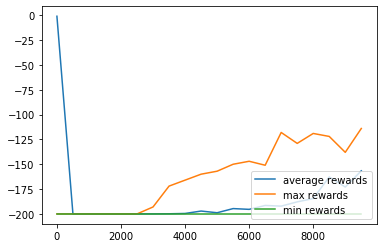

In [24]:
plt.plot(agg_ep_rewards['ep'], agg_ep_rewards['avg'], label="average rewards")
plt.plot(agg_ep_rewards['ep'], agg_ep_rewards['max'], label="max rewards")
plt.plot(agg_ep_rewards['ep'], agg_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.show()